[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Fine-Tune YOLO for Fire Detection**

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

## 🎯 Objective

This notebook provides a complete guide to building a custom fire detection system using a YOLO segmentation model. The workflow covers every step, from creating a dataset with video annotations and converting them to the required format, to fine-tuning the model and performing real-time inference on video streams.


## 🚀 Key Features

* **Video Dataset Creation**: Using videos as the primary data source for training a robust detection model.
* **Format Conversion**: Transforming video annotations in COCO JSON format into the YOLO segmentation format.
* **Model Training**: Fine-tuning a pre-trained `yolov8x-seg.pt` model on a custom fire dataset.
* **Video Inference**: Applying the trained model to a video to detect fire and overlay visual alerts with segmentation masks.


## 📚 Libraries & Prerequisites

* **Core Libraries**: `ultralytics`, `opencv-python`, `matplotlib`.
* **Environment**: A Python environment with GPU support is highly recommended for efficient model training.
* **Dataset**: A dataset of fire videos and a corresponding `annotations.json` file created using an annotation tool like Labellerr.


### **Dataset Creation and Annotation**

The foundation of our model is the dataset. This step involves collecting videos containing fire and annotating them. For segmentation, this means drawing precise polygons around the fire on each relevant frame using an annotation tool and then exporting the annotations in COCO JSON format.

Create a dataset of fire Videos and annotate them using [Labellerr](https://www.labellerr.com)

### **Convert JSON to YOLO format**

YOLO models require a specific text-based annotation format. We'll clone a utility repository containing a script that converts our video annotations from COCO JSON. This script automatically extracts the annotated frames and creates the corresponding `.txt` label files for training.

In [2]:
!git clone https://github.com/Labellerr/yolo_finetune_utils.git

Cloning into 'yolo_finetune_utils'...


In [3]:
from yolo_finetune_utils.video_annotation.yolo_converter import convert_to_yolo_segmentation

In [4]:
convert_to_yolo_segmentation(
        annotation_path="annotations.json",
        videos_dir="dataset",
        use_split=True,
        split_ratio=(0.5, 0.4, 0.1),  # 50% train, 40% val, 10% test
        output_dir="yolo_format"
    )

Using split ratio: Train=0.5, Val=0.4, Test=0.1
Creating output directory structure in: yolo_format
Loading JSON annotation file...
Found classes: ['Fire']
Aggregating annotations from JSON...


Processing files in JSON: 100%|██████████| 3/3 [00:00<00:00, 13.10it/s]



Extracting frames and saving to YOLO format...
Processing train set (812 frames)...


Exporting train set: 100%|██████████| 812/812 [03:38<00:00,  3.72it/s]


Processing val set (650 frames)...


Exporting val set: 100%|██████████| 650/650 [02:48<00:00,  3.86it/s]


Processing test set (163 frames)...


Exporting test set: 100%|██████████| 163/163 [00:43<00:00,  3.71it/s]


Creating data.yaml file...

Conversion complete! ✨
Dataset saved to: d:\professional\USE_CASE_PROJECT\Smart city\TUTORIAL\yolo_format
YAML file saved to: d:\professional\USE_CASE_PROJECT\Smart city\TUTORIAL\yolo_format\data.yaml


### **Model Training on Custom Dataset**

With the dataset prepared, we can now fine-tune the segmentation model. We'll use the powerful `ultralytics` library and start with a pre-trained `yolov8x-seg.pt` checkpoint to leverage transfer learning, training it on our custom fire dataset for 200 epochs.

In [5]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [ ]:
model = YOLO("yolov8x-seg.pt")
model.train(data="yolo_format/data.yaml", epochs=200, imgsz=640, batch=30)

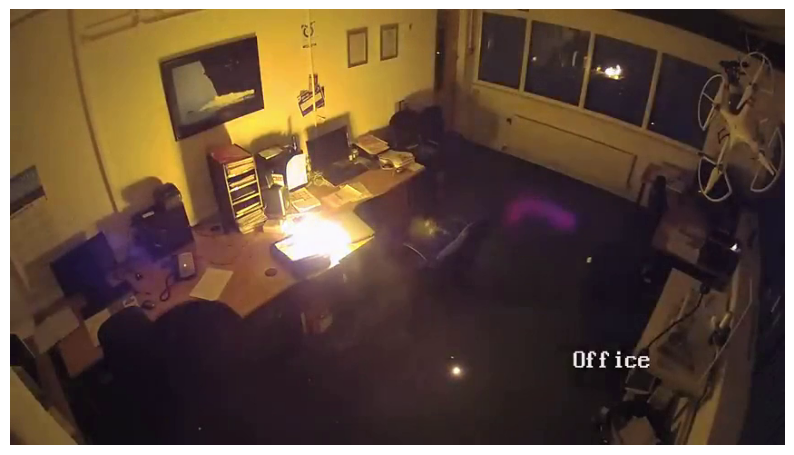

In [8]:
cap = cv2.VideoCapture("dataset/1_cut.mp4")

if cap.isOpened() == False:
    print("Error opening video stream or file")

cap.set(cv2.CAP_PROP_POS_FRAMES, 300)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

plt.figure(figsize=(10, 6))
plt.imshow(frame)
# plt.imsave('frame.png', frame)
plt.axis('off')
plt.show()

Before processing a full video, we'll test the model on a single frame to ensure it's working correctly. We extract a frame from a test video, run the prediction, and use `matplotlib` to visualize the resulting segmentation mask.


0: 384x640 1 Fire, 1815.0ms
Speed: 379.1ms preprocess, 1815.0ms inference, 24.5ms postprocess per image at shape (1, 3, 384, 640)


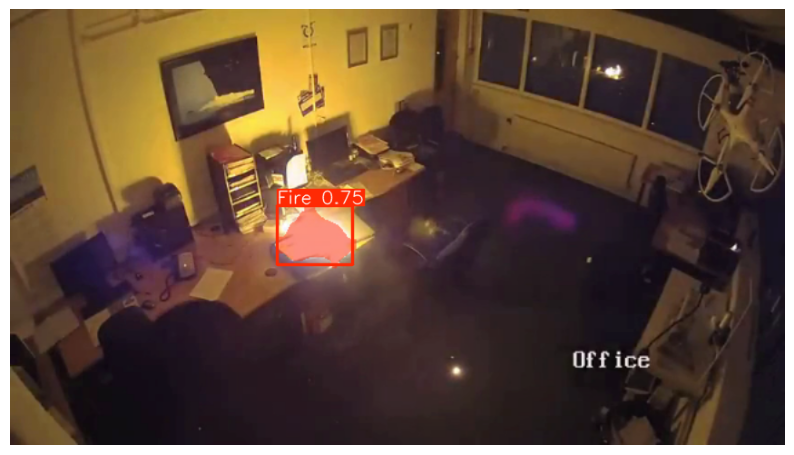

In [9]:
model = YOLO("runs/segment/train2/weights/last.pt")
result = model.predict(source=frame, conf=0.25)


plt.figure(figsize=(10, 6))
plt.axis('off')
plt.imshow(result[0].plot())

### **Model Inference on Video**

Finally, we'll create a pipeline to process an entire video. This script reads the video frame by frame, runs our fine-tuned model for inference, and if a fire is detected, it draws a translucent red overlay and a solid outline around the mask. It also adds a "Fire Detected" label before writing the processed frame to a new output video file.

In [10]:
import cv2
import numpy as np

video_path = "assests/3_cut.mp4"
output_path = "3_output.mp4"

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.predict(source=frame_rgb, conf=0.1)
    masks = results[0].masks

    mask_detected = masks is not None and masks.data.shape[0] > 0

    if mask_detected:
        # Take first mask (if multiple, loop over masks.data)
        mask = masks.data[0].cpu().numpy()
        mask = cv2.resize(mask, (width, height))
        mask = (mask > 0.5).astype(np.uint8)

        # --- Translucent red fill ---
        red_overlay = np.zeros_like(frame, dtype=np.uint8)
        red_overlay[:] = (0, 0, 255)  # Red in BGR
        frame = np.where(mask[:, :, None] == 1,
                         cv2.addWeighted(frame, 0.5, red_overlay, 0.5, 0),
                         frame)

        # --- Solid red outline ---
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(frame, contours, -1, (0, 0, 255), 3)  # thickness=3

        # Draw "Fire Detection" label
        label = "Fire Detected"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        thickness = 2
        text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)
        text_w, text_h = text_size
        x, y = width - text_w - 20, 40

        # Red rectangle background
        cv2.rectangle(frame, (x - 10, y - text_h - 10),
                      (x + text_w + 10, y + 10), (0, 0, 255), -1)
        # White text
        cv2.putText(frame, label, (x, y), font, font_scale,
                    (255, 255, 255), thickness, cv2.LINE_AA)

    out.write(frame)

cap.release()
out.release()